# 1. Import modules

In [1]:
# import base libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# training GAN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torch import autograd

# wavlet decomposition, denoise signal
import pywt
from pywt import wavedec

# Import functions
%run ./model.ipynb
%run ./utils.ipynb

# Helper functions

In [2]:
def read_files(path):
    # Read files in path
    files = os.listdir(path)
    
    # create empty lists to store the signals
    labels, ECG, ABP, CVP = [], [], [], []
    patients = []
    for file in files:
       # if '120' in file:
        # extract label from the file name
        split_file = file.split('_')
        labels.append(f'{split_file[1]}_{split_file[2]}')
        patients.append(split_file[0])

        # read data from csv file (it has 5 columns)
        file_path =  f'{path}/{file}'
        df = pd.read_csv(file_path).dropna()

        # store the signals
        ECG.append(df['ECG'].to_numpy())  
        ABP.append(df['ABP'].to_numpy())  
        CVP.append(df['CVP'].to_numpy())  
        
    return labels, ECG, ABP, CVP , patients

def denoise_signal(X, dwt_transform = 'db4', cutoff_low=1, cutoff_high=10):
    X_denoised = []
    for j in range(len(X)):
        coeffs = wavedec(X[j], dwt_transform)   # wavelet transform 'bior4.4'
        # scale 0 to cutoff_low 
        for ca in range(0,cutoff_low):
            coeffs[ca]=np.multiply(coeffs[ca],[0.0])
        # scale cutoff_high to end
        for ca in range(cutoff_high, len(coeffs)):
            coeffs[ca]=np.multiply(coeffs[ca],[0.0])
        Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform

        X_denoised.append(Y)
    return X_denoised


def segmentation(ECG, ABP, CVP, labels, fs=1000):
    segmented_ecg, segmented_abp, segmented_cvp, s_labels = [],[],[],[]
    for i in range(0,len(ECG)):
        r_peaks, freq = scipy.signal.find_peaks(-ECG[i], height= 0.4*np.max(-ECG[i]), distance=int(0.4*fs))
        
        before = int(0.4*fs)
        after = int(0.4*fs)
        for j in range(0,len(r_peaks)):
            if  r_peaks[j]-before>0 and r_peaks[j]+after+before<len(ECG[i]):
                
                ecg_slice = ECG[i][r_peaks[j]-before:r_peaks[j]+after]
#                 abp_slice = ABP[i][r_peaks[j]-before:r_peaks[j]+after]
#                 cvp_slice = CVP[i][r_peaks[j]-before:r_peaks[j]+after]
                
                segmented_ecg.append(ecg_slice)
                segmented_abp.append(ABP[i][r_peaks[j]-int(0.2*fs):r_peaks[j]+after+before-int(0.2*fs)]) 
                segmented_cvp.append(CVP[i][r_peaks[j]-int(0.2*fs):r_peaks[j]+after+before-int(0.2*fs)])
                s_labels.append(labels[i])
#     # Down-sample the signals from 1000Hz to 250Hz
#     segmented_abp = down_sample(segmented_abp)
#     segmented_ecg = down_sample(segmented_ecg) 
#     segmented_cvp = down_sample(segmented_cvp) 
    #signals = [np.stack((segmented_ecg[i], segmented_abp[i]), axis=0) for i in range(0,len(segmented_ecg))]   #   segmented_cvp[i]
    return s_labels, segmented_ecg, segmented_abp, segmented_cvp    

# Pre-processing

In [4]:
# Read the signals
labels, ECG, ABP, CVP, patients = read_files('Z:/1938759/Datasets/Split files-20230404T094114Z-001/Split files')

#Denoise the signals using wavelet decomposition
ECG = denoise_signal(ECG, dwt_transform= 'bior4.4', cutoff_low=2, cutoff_high=10)
BP = denoise_signal(ABP, dwt_transform= 'db3', cutoff_low=1, cutoff_high=12)
CVP = denoise_signal(CVP, dwt_transform= 'bior4.4', cutoff_low=1, cutoff_high=9)

# # smooth the signals
ECG = Savitzky_Golay(ECG, fs=1000)
ABP = Savitzky_Golay(ABP, fs=1000)
CVP = Savitzky_Golay(CVP, fs=1000)

# Normalise signals between -1 and 1
ECG = normalise(ECG ,-1, 1)
ABP = normalise(ABP, -1, 1)
CVP = normalise(CVP, -1, 1)

# # Normalise signals mean zero and std
# ECG = normalise(ECG)
# ABP = normalise(ABP)

# Segment the signals into 1.7s splits
labels_segments, segmented_ecg, segmented_abp, segmented_cvp = segmentation(ECG, ABP, CVP, labels)
signals = [np.stack((segmented_ecg[i], segmented_abp[i], segmented_cvp[i]), axis=0) for i in range(0,len(segmented_ecg))]  #, 

selected_labels = [i for i, label in enumerate(labels_segments) if label in {'APVP_AVD120', 'APVP_AVD160', 'APVP_AVD200', 'APVP_AVD40', 'APVP_AVD80', 'APVP_AVD240', 'APVP_AVD280', 'APVS_AVD240','APVS_AVD280', 'APVS_AVD320', 'APVS_AVD200', 'APVS_AVD220'}]  #'APVS_AVD240','APVS_AVD280','APVS_AVD320','APVS_AVD200','APVS_AVD220'

labels_segments = [label for i, label in enumerate(labels_segments) if i in selected_labels]
signals = [signal for i, signal in enumerate(signals) if i in selected_labels]


In [5]:
APVS_AVD280 = []
for i in range(0,len(labels_segments)):
    if labels_segments[i] =='APVS_AVD280':
        APVS_AVD280.append(i)
        
APVS_AVD280 = [signals[i] for i in APVS_AVD280]

In [6]:
# encode the labels
unique, counts = np.unique(labels_segments, return_counts=True)
print(unique, counts)

from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
labels_enc = enc.fit_transform(labels_segments).tolist()
unique, counts = np.unique(labels_enc, return_counts=True)
print(unique, counts)

['APVP_AVD120' 'APVP_AVD160' 'APVP_AVD200' 'APVP_AVD240' 'APVP_AVD280'
 'APVP_AVD40' 'APVP_AVD80' 'APVS_AVD200' 'APVS_AVD220' 'APVS_AVD240'
 'APVS_AVD280' 'APVS_AVD320'] [4314 1015  629  249  150 1143 1084   82   67  592  393   70]
[ 0  1  2  3  4  5  6  7  8  9 10 11] [4314 1015  629  249  150 1143 1084   82   67  592  393   70]


APVP_AVD200


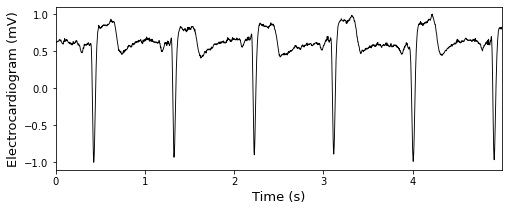

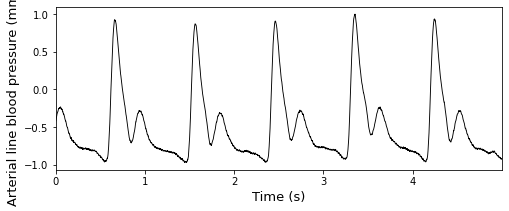

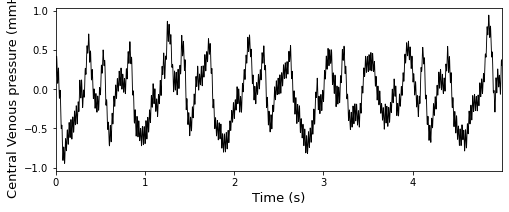

In [7]:
Fs = 1000;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,len(ECG[0][:5000])/Fs,Ts) # time vector


k=140
print(labels_segments[k])
plt.figure(figsize=(8,3))
plt.plot(t,ECG[1][:5000], color='black', linewidth=0.9)
plt.xlabel('Time (s)',  fontsize = 13)
plt.ylabel('Electrocardiogram (mV)', fontsize = 13)
plt.margins(x=0)
#plt.title("Atrial paced, Ventricular sensed, ADV=240")
#plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(t,ABP[1][:5000], color='black', linewidth=0.9)
plt.xlabel('Time (s)',  fontsize = 13)
plt.ylabel('Arterial line blood pressure (mmHg)', fontsize = 13)
plt.margins(x=0)
#plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(t,CVP[1][:5000], color='black', linewidth=0.9)
plt.xlabel('Time (s)',  fontsize = 13)
plt.ylabel('Central Venous pressure (mmHg)', fontsize = 13)
plt.margins(x=0)
#plt.legend()
plt.show()

In [8]:
#signals = torch.from_numpy(np.array(signals, dtype=np.float32))
labels_enc = torch.from_numpy(np.array(labels_enc, dtype=int))

train_data =[([signals[i], labels_enc[i]]) for i in range(len(labels_enc))]

In [9]:
np.shape(signals)[1]

3

# Model

**Discriminator**

In [10]:
class CNN_Discriminator(nn.Module):
    # Code copied from https://github.com/vlbthambawita/deepfake-ecg/blob/9fa9a02a9fefe579e322d56fa591c3887d7ad135/deepfakeecg/models/pulse2pulse.py#L5
   
    def __init__(self, num_classes, signal_length, model_size=64, ngpus=1, num_channels=2, shift_factor=2,
                 alpha=0.2, verbose=False):
        super(CNN_Discriminator, self).__init__()
        self.num_classes = num_classes
        self.signal_length = signal_length
        self.model_size = model_size  # d
        self.ngpus = ngpus
        self.num_channels = num_channels  # c
        self.shift_factor = shift_factor  # n
        self.alpha = alpha
        self.verbose = verbose
        
        self.embed = nn.Embedding(num_classes, 1*signal_length)
        self.conv1 = nn.Conv1d(num_channels+1,  model_size, 5, stride=2, padding=1)
        self.conv2 = nn.Conv1d(model_size, 2 * model_size, 5, stride=2, padding=1)
        self.conv3 = nn.Conv1d(2 * model_size, 5 * model_size, 5, stride=2, padding=1)
        self.conv4 = nn.Conv1d(5 * model_size, 10 * model_size, 5, stride=2, padding=1)
        self.conv5 = nn.Conv1d(10 * model_size, 20 * model_size, 5, stride=2, padding=1)
        self.conv6 = nn.Conv1d(20 * model_size, 25 * model_size, 5, stride=4, padding=1)
        self.conv7 = nn.Conv1d(25 * model_size, 100 * model_size, 5, stride=4, padding=1)

        self.fc1 = nn.Linear(9600, 1)
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
#                  nn.init.normal_(m.weight.data, 0.0, 0.02)
                 
#                     #nn.init.kaiming_normal_(m.weight.data)   #kaiming_normal_

    def forward(self, x, labels):
        #print(x.shape)
        embedding = self.embed(labels).view(labels.shape[0], 1,self.signal_length) 
        #print(embedding.shape)
        x = torch.cat([x,embedding], dim=1) # N x C x channel_signal x signal_length
        
        
        x = F.leaky_relu(self.conv1(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        
        x = F.leaky_relu(self.conv2(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        
        x = F.leaky_relu(self.conv3(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)  

        x = F.leaky_relu(self.conv4(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        
        
        x = F.leaky_relu(self.conv5(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)
        #x = self.ps5(x)
        

        x = F.leaky_relu(self.conv6(x), negative_slope=self.alpha)
        if self.verbose:
            print(x.shape)

        x = x.view(-1, x.shape[1] * x.shape[2])
  
        if self.verbose:
            print(x.shape)

        return self.fc1(x)

**Generator**

In [11]:
'''Adapted from https://github.com/milesial/Pytorch-UNet by James Howard (2D -> 1D)'''

class DoubleConv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_ch, out_ch, 3, padding=1)
    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        #x = self.bn(x)
        x = self.relu(x)
        return x

class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=None):
        super(Down, self).__init__()
        self.dropout = dropout
        self.maxpool = nn.MaxPool1d(2)
        self.dbc = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.maxpool(x)
        x = self.dbc(x)
        if self.dropout:
            x = F.dropout(x, self.dropout)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, diff - diff // 2))
        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1) # dim=1 because we add them on channel dimension 
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)
    def forward(self, x):
        x = self.conv(x)
        return x


class UNet1D(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes, embed_size, n_layers, ngpus=1, starting_layers=128, dropout=None):
        super(UNet1D, self).__init__()
        self.dropout = dropout
        self.n_layers = n_layers
        self.inc = InConv(in_channels+1, starting_layers)
        self.down1 = Down(starting_layers * 1, starting_layers * 2, dropout)  # Only dropout on early layers
        self.down2 = Down(starting_layers * 2, starting_layers * 4, dropout)
        self.down3 = Down(starting_layers * 4, starting_layers * 8, dropout)
        self.down4 = Down(starting_layers * 8, starting_layers * 8, dropout)
        if self.n_layers >= 5:
            self.down5 = Down(starting_layers * 8, starting_layers * 8)
            if self.n_layers >= 6:
                self.down6 = Down(starting_layers * 8, starting_layers * 8)
                self.up6 = Up(starting_layers * 16, starting_layers * 8)
            self.up5 = Up(starting_layers * 16, starting_layers * 8)
        self.up4 = Up(starting_layers * 16, starting_layers * 4)
        self.up3 = Up(starting_layers * 8, starting_layers * 2)
        self.up2 = Up(starting_layers * 4, starting_layers)
        self.up1 = Up(starting_layers * 2, starting_layers)
        self.out = OutConv(starting_layers, out_channels)
        self.embed = nn.Embedding(num_classes, embed_size)
        
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
    def forward(self, x,labels):
        embedding = self.embed(labels).unsqueeze(1)#.unsqueeze(3) # adds 1 x 1 at the end
        #print(embedding.shape)
        #print(x.shape)
        x = torch.cat([x, embedding],dim=1)
        #print(x.shape)
        
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        if self.n_layers >= 4:
            x5 = self.down4(x4)
            x = x5
            if self.n_layers >= 5:
                x6 = self.down5(x5)
                x = x6
                if self.n_layers >= 6:
                    x7 = self.down6(x6)
                    x = x7
                    x = self.up6(x, x6)
                x = self.up5(x, x5)
            x = self.up4(x, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        x = torch.tanh(self.out(x))
        
        # latent vector z: N x noise_dim x 1 x 1
        
        return x


In [12]:
def gradient_penalty(critic, labels, real, fake, device):
    BATCH_SIZE, H, W = real.shape

    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, H, W).to(device)
    
    # Interpolate between real and fake data
    interpolates = real * alpha + fake * (1 - alpha)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    # Calculate critic scores
    mixed_scores = critic(interpolates,labels)

    # Take the gradient of the scores with respect to the input signals
    gradient = torch.autograd.grad(
        inputs=interpolates,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty    

def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            #nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.kaiming_normal_(m.weight.data)

# Set up the WGAN hyperparameters

In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = 'b8b8e375fa11f69790bff448e326c90a5435494b'
os.environ["WANDB_MODE"] = "offline"

In [13]:
# Set the random seed for NumPy
np.random.seed(42)

# Set the random seed for PyTorch (CPU)
torch.manual_seed(42)

# If using GPU, set the random seed for CUDA as well
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# Hyperparameters 
channels_signal = 3
latent_dim = np.shape(np.array(signals))[2]
generator_layers = 6

batch_size = 16
discriminator_updates = 5
num_epochs = 1000

num_classes = len(unique)
embed_size = np.shape(np.array(signals))[2]
signal_length = np.shape(np.array(signals))[2]

LAMBDA_GP = 10
no_of_batches = len(signals)/batch_size 
batches_per_epoch = round(len(signals)/batch_size)

gen_name = f"Gen_paced_all_{num_epochs}_3C"
disc_name = f"Disc_paced_all_{num_epochs}_3C"

In [ ]:
embed_size

In [ ]:
# capture a dictionary of hyperparameters with config
device =  "cuda" #if torch.cuda.is_available() 
config = {"learning_rate_critic": 0.00001, 
          "learning_rate_generator": 0.00001, #0.00005 ,
          "epochs": num_epochs,
          "Channels": channels_signal,
          "architecture": "connections_instancenorm",
          "dropout":"none",
          "machine": "GPU_server",
          "batch_size": batch_size, 
          "generator_layers": generator_layers, 
          "discriminator_updates":discriminator_updates,
          "LAMBDA_GP":LAMBDA_GP, 
          "Optimizer":'Adam+betas0and0.9', 
          "Generator":'UNet1D', 
          "Discriminator":'CNN', 
          "data": "all_butnotfused_3C",
          "type_GAN":'CGAN', 
          "classes":unique,
          "gen_name": gen_name,
          "disc_name": disc_name
         }

In [ ]:
with wandb.init(project='WGAN_paced', entity='ioanacretu', config=config):
    config = wandb.config

    # Create dataset and dataloader
    #dataloader = DataLoader(ECG_BP,batch_size=config.batch_size, shuffle=True, num_workers=2)
    trainloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True)

    # Create discriminator and generator
    critic = CNN_Discriminator(num_classes, signal_length, num_channels=channels_signal).to(device) 
    generator = UNet1D(channels_signal, channels_signal, num_classes, embed_size, n_layers=config.generator_layers).to(device)

    initialize_weights(critic)
    initialize_weights(generator)

    # Set up Optimizer for G and D
    optimizer_critic =  optim.Adam(critic.parameters(), lr=config.learning_rate_critic, betas=(0, 0.9))
    optimizer_generator = optim.Adam(generator.parameters(), lr=config.learning_rate_generator, betas=(0, 0.9))

#         optimizer_critic =  optim.Adam(critic.parameters(), lr=config.learning_rate, betas=(0, 0.9))
#         optimizer_generator = optim.Adam(generator.parameters(),lr=config.learning_rate, betas=(0, 0.9))

    # Watch weights and gradients for both critic and generator
    wandb.watch(critic, log="all")
    wandb.watch(generator, log="all")

    #fixed_noise = torch.randn(batch_size,latent_dim,1).to(device)
    fixed_noise = torch.randn(config.batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
    fixed_labels = torch.randint(low=0, high=num_classes, size=(config.batch_size,)).to(device)

#         if wandb.run.resumed:
#             checkpoint_filename_disc = f"\disc_APVP_AVD200_epoch{epoch + 1}.pth"
#             checkpoint_filename_gen = f"\gen_APVP_AVD200_epoch{epoch + 1}.pth"
#             checkpoint_path_disc = 
#             checkpoint_path_gen = 

#             checkpoint = torch.load(wandb.restore(CHECKPOINT_PATH))
#             model.load_state_dict(checkpoint['model_state_dict'])
#             optimizer_generator.load_state_dict(checkpoint['optimizer_state_dict'])
#             epoch = checkpoint['epoch']
#             loss = checkpoint['loss']


    critic_iter = 0
    gen_iter = 0


    print("Starting training...")
    for epoch in range(config.epochs):

        # set both networks for training mode
        generator.train()
        critic.train()

        # initiate the epoch loss for both networks to zero
        batch_nr = 0
        epoch_loss_critic = 0.
        epoch_loss_generator = 0.
        all_loss_critic = 0.

        print(f'Epoch: {epoch}')
        for batch_idx, (data,labels) in enumerate(trainloader):
            step_loss_critic = 0.
            batch_nr += 1

            data = data.to(device)
            labels = labels.to(device)
            data = data.float()  #solved error "Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same"
            count=0
            # Train the Critic/Discriminator: max E[critic(real)] - E[critic(fake)]
            for _ in range(config.discriminator_updates):
                critic_iter = critic_iter +1
                count = count+1
                noise = torch.randn(config.batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
                fake = generator(noise,labels)

                critic_real = critic(data,labels).reshape(-1)
                critic_fake = critic(fake.detach(),labels).reshape(-1)   #critic(fake,labels).reshape(-1) #here we changed according to github repo alladin, it was before critic_fake = critic(fake.detach(),labels).reshape(-1)

                gp = gradient_penalty(critic,labels, data, fake, device = device)
                loss_critic =(-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
                wandb.log({"Epoch":epoch, "Critic_loss": loss_critic, "Critic_iteration": critic_iter})

                step_loss_critic += loss_critic.item()
                critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                optimizer_critic.step()
            #all_loss_critic += step_loss_critic/discriminator_updates    
           ## clear memory after a no of steps: is it enought to keep the w. for disc_updates steps? ##loss_critic.backward(retain_graph=False)
            # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
            gen_iter = gen_iter + 1
            gen_fake = critic(fake,labels).reshape(-1)
            loss_generator = -torch.mean(gen_fake)
            #epoch_loss_generator += loss_generator.item()

            generator.zero_grad()
            loss_generator.backward()
            optimizer_generator.step()
            wandb.log({"Epoch":epoch, "Generator_iteration": gen_iter, "Generator_loss": loss_generator})   

        print(f"Gen loss:{loss_generator}")
        print(f"Critic loss::{np.mean(step_loss_critic)}")   

#             # Save model checkpoints
#             if (epoch + 1) % 500 == 0:
#                 checkpoint_filename_disc = f"\disc_APVP_AVD200_epoch{epoch + 1}.pth"
#                 checkpoint_filename_gen = f"\gen_APVP_AVD200_epoch{epoch + 1}.pth"

#                 checkpoint_path_disc = wandb.run.dir + checkpoint_filename_disc
#                 checkpoint_path_gen = wandb.run.dir + checkpoint_filename_gen

#                 torch.save({'epoch': epoch,'model_state_dict': critic.state_dict(),
#                             'optimizer_state_dict': optimizer_critic.state_dict(),
#                             'loss': config.learning_rate_critic,}, checkpoint_path_disc)
#                 wandb.save(checkpoint_path_disc)

#                 torch.save({'epoch': epoch,'model_state_dict': generator.state_dict(),
#                             'optimizer_state_dict': optimizer_generator.state_dict(),
#                             'loss': config.learning_rate_generator,}, checkpoint_path_gen)
#                 wandb.save(checkpoint_path_gen)

        # Diplay the signals produced by the generator every 100 epochs
        if (epoch + 1) % 100 == 0:
            generator.eval()
            with torch.no_grad():
                generated_signals = generator(fixed_noise, fixed_labels)
                gener = generated_signals.cpu().detach().numpy()

                plt.figure(figsize=(8,3))
                plt.subplot(311)
                plt.title(f'Label: {fixed_labels[0]}')
                plt.plot(gener[0][0])
                plt.subplot(312)
                plt.plot(gener[0][1])
                plt.subplot(313)
                plt.plot(gener[0][2])

                # Log the figure to WandB
                wandb.log({'chart': plt})
print('Finished Training')

In [ ]:
n=5

plt.figure(figsize=(8,3))
plt.subplot(311)
plt.title(f'Label: {labels[n]}')
plt.plot(gener[n][0])
plt.margins(0)
plt.subplot(312)
plt.plot(gener[n][1])
plt.subplot(313)
plt.plot(gener[n][2])

plt.margins(0)

In [ ]:
n=3
plt.figure(figsize=(8,3))
plt.subplot(311)
plt.title(f'Label: {labels[n]}')
plt.plot(signals[n][0])
plt.margins(0)
plt.subplot(312)
plt.plot(signals[n][1])
plt.subplot(313)
plt.plot(signals[n][2])

plt.margins(0)

# Save the models

In [ ]:
disc_name

In [ ]:
PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_paced\3channels'
torch.save(generator.state_dict(), os.path.join(PATH,f'{gen_name}.pth'))
torch.save(critic.state_dict(), os.path.join(PATH,f'{disc_name}.pth'))

# Load the generator and test it

In [ ]:
iterator = iter(trainloader)
data, labels = next(iterator)

In [ ]:
np.unique(labels_enc, return_counts=True)

In [ ]:
device =  "cuda" if torch.cuda.is_available() else "cpu"  #
import random

channels_signal = 3
num_classes=12
embed_size = 800
latent_dim = 800
generator_layers = 6

generator_PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_paced\3channels\Gen_paced_all_1000_3C.pth'
generator_loaded = UNet1D(channels_signal, channels_signal, num_classes,embed_size, n_layers = generator_layers).to(device)
generator_loaded.load_state_dict(torch.load(generator_PATH))
generator_loaded.eval()

#generator = generator.to(device)
labels = np.zeros(393)
for i in range(len(labels)):
    labels[i] = 10 # random.randrange(0,6,1)
    
batch_size = len(labels)
latent_dim = 800
fixed_noise = torch.randn(batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
labels =  torch.Tensor(labels).to(device)
labels = labels.int()

generated_signals = generator_loaded(fixed_noise,labels)
gener = generated_signals.cpu().detach().numpy()

## Evaluate all labels

In [14]:
import random
import numpy as np
import torch
from frechetdist import frdist
import math
import time
from dtaidistance import dtw

class GANEvaluator:
    def __init__(self, real_signals, fake_signals, device):
        self.device = device
        self.real_signals = [torch.tensor(signal, device=self.device).float() for signal in real_signals]
        self.fake_signals = [torch.tensor(signal, device=self.device).float() for signal in fake_signals]
        self.time = torch.arange(0, len(self.real_signals[0]), device=self.device) / 360

    def shuffle_data(self, data):
        random.shuffle(data)

    def frechet_distance(self):
        frechet_distances = []
        for real_points in self.real_signals:
            P = torch.stack([self.time, real_points], dim=1).cpu().numpy()
            fd = []
            for fake_points in self.fake_signals:
                Q = torch.stack([self.time, fake_points], dim=1).cpu().numpy()
                fd.append(frdist(P, Q))
            frechet_distances.append(min(fd))
        return np.mean(frechet_distances)

    def calculate_metric(self, metric_func):
        metrics = []
        for real_points in self.real_signals:
            tmp_metrics = []
            for fake_points in self.fake_signals:
                if len(real_points) != len(fake_points):
                    raise ValueError("Both lists of signals must have the same length.")
                tmp_metrics.append(metric_func(real_points, fake_points).item())
            metrics.append(min(tmp_metrics))
        return np.mean(metrics)

    def MSE(self, real, fake):
        return (real - fake).pow(2).mean()

    def RMSE(self, real, fake):
        return torch.sqrt((real - fake).pow(2).mean())

    def MAE(self, real, fake):
        return torch.abs(real - fake).mean()

    def calculate_prmse(self):
        prmse_values = []
        for real_points in self.real_signals:
            max_real_value = torch.max(real_points)
            tmp_squared_errors = []
            for fake_points in self.fake_signals:
                rmse = torch.sqrt(((real_points - fake_points) ** 2).mean()).item()
                tmp_squared_errors.append(rmse ** 2)
            min_squared_error = min(tmp_squared_errors)
            prmse_percentage = (np.sqrt(min_squared_error) / max_real_value.item()) * 100
            prmse_values.append(prmse_percentage)
        return np.mean(prmse_values)

#     # DTW calculation method
#     def DTW(self, real, fake):
#         n, m = len(real), len(fake)
#         dtw_matrix = np.full((n+1, m+1), np.inf)
#         dtw_matrix[0, 0] = 0

#         for i in range(1, n+1):
#             for j in range(1, m+1):
#                 cost = abs(real[i-1] - fake[j-1])
#                 dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

#         return dtw_matrix[n, m]

#     # Method to calculate DTW for all real-fake pairs and return the average
#     def calculate_dtw_distance(self):
#         dtw_distances = []
#         for real_signal in self.real_signals:
#             dtw_per_real = []
#             for fake_signal in self.fake_signals:
#                 dtw_per_real.append(self.DTW(real_signal.cpu().numpy(), fake_signal.cpu().numpy()))
#             dtw_distances.append(min(dtw_per_real))
#         return np.mean(dtw_distances)

    def gaussian_kernel(self, X, Y, sigma=1.0):
        XX = torch.matmul(X, X.T)
        XY = torch.matmul(X, Y.T)
        YY = torch.matmul(Y, Y.T)
        X_sqnorms = torch.diagonal(XX)
        Y_sqnorms = torch.diagonal(YY)
        
        K = torch.exp(-0.5 * (X_sqnorms[:, None] + Y_sqnorms[None, :] - 2 * XY) / sigma**2)
        return K
    
    def mmd(self, sigma=1.0):
        mmd_distances = []
        for real_points in self.real_signals:
            P = real_points.unsqueeze(1)
            mmd_values = []
            for fake_points in self.fake_signals:
                Q = fake_points.unsqueeze(1)
                
                K_PP = self.gaussian_kernel(P, P, sigma)
                K_QQ = self.gaussian_kernel(Q, Q, sigma)
                K_PQ = self.gaussian_kernel(P, Q, sigma)
                
                mmd_value = K_PP.mean() + K_QQ.mean() - 2 * K_PQ.mean()
                mmd_values.append(mmd_value.item())
            mmd_distances.append(min(mmd_values))
        return np.mean(mmd_distances)
    
    def dtw_distance(self):
        dtw_distances = []
        for real_signal in self.real_signals:
            real_signal = real_signal.cpu().numpy()
            dtw_per_real = []
            for fake_signal in self.fake_signals:
                fake_signal = fake_signal.cpu().numpy()
                if real_signal.ndim == 1 and fake_signal.ndim == 1:
                    # Univariate case
                    distance = dtw.distance(real_signal, fake_signal)
                    dtw_per_real.append(distance)
                elif real_signal.ndim == 2 and fake_signal.ndim == 2:
                    # Multivariate case: compute DTW for each dimension and take the average
                    distances = [dtw.distance(real_signal[:, i], fake_signal[:, i]) for i in range(real_signal.shape[1])]
                    distance = np.mean(distances)
                    dtw_per_real.append(distance)
                else:
                    raise ValueError("Mismatched dimensions between real and fake signals")
            if dtw_per_real:
                dtw_distances.append(min(dtw_per_real))
        if dtw_distances:
            return np.mean(dtw_distances)
        else:
            return float('inf')  # or some other appropriate value for no signals
    
    
def evaluate_all(path, generated_samples):
    
    signal_labels_numeric = [7,  8,  9, 10, 11]  #list(np.unique(labels_enc, return_counts=False))  #    #
    signal_labels_real = ['APVS_AVD200','APVS_AVD220', 'APVS_AVD240', 'APVS_AVD280', 'APVS_AVD320']  # list(np.unique(labels_segments, return_counts=False))  ## 
    
    device =  "cuda" if torch.cuda.is_available() else "cpu"  
    
    channels_signal = 3
    num_classes=12
    embed_size = 800
    latent_dim = 800
    generator_layers = 6

    generator_PATH = r'Z:\1938759\Synhtetic signal simulator\Our-data\models_paced\3channels\Gen_paced_all_1000_3C.pth'
    generator_loaded = UNet1D(channels_signal, channels_signal, num_classes,embed_size, n_layers = generator_layers).to(device)
    generator_loaded.load_state_dict(torch.load(generator_PATH))
    generator_loaded.eval()

    for i in range(len(signal_labels_numeric)):
        labels = np.zeros(generated_samples)
        batch_size = len(labels)
        
        for j in range(len(labels)):
            labels[j] = signal_labels_numeric[i] 

        fixed_noise = torch.randn(batch_size,channels_signal,latent_dim).uniform_(-1, 1).to(device)
        labels =  torch.Tensor(labels).to(device)
        labels = labels.int()

        generated_signals = generator_loaded(fixed_noise,labels)
        gener = generated_signals.cpu().detach().numpy()
        
        # Identify the heartbeats/signals that have the label the same as the selected label from the list
        real_beats = []
        for k in range(0,len(labels_segments)):
            if labels_segments[k] == signal_labels_real[i]:
                real_beats.append(i)

        real_beats = [np.array(signals[i]) for i in real_beats]
        #real_beats =  np.array(real_beats).reshape((len(real_beats), 1, 800))
        random_selected = random.sample(list(real_beats), generated_samples)
        
        list_sig_type = ['ECG', 'ABP', 'CVP']
        
        for k in range(np.shape(real_beats)[1]):
            orig_signal_type = [random_selected[i][k] for i in range(len(random_selected))]
            gener_signal_type = [gener[i][k] for i in range(len(gener))]
        
            print(f'The signal evaluated is: {list_sig_type[k]}')
            print(f'The class evaluated is: {signal_labels_real[i]}')
            
            # Prepare the data 
#             original_data = np.squeeze(np.array(orig_signal_type), axis=1)
#             generated_data = np.squeeze(np.array(gener_signal_type), axis=1)

            # Instantiate the GANEvaluator class
            gan_evaluator = GANEvaluator(orig_signal_type, gener_signal_type, device)

            # Call each function on the instance and # Print the results
            gan_evaluator.shuffle_data(orig_signal_type)

#             start_time = time.time()

#             mse_value = gan_evaluator.calculate_metric(gan_evaluator.MSE)
#             print(f'MSE value for ECG signals is: {mse_value}')
#             rmse_value = gan_evaluator.calculate_metric(gan_evaluator.RMSE)
#             print(f'RMSE value for ECG signal is: {rmse_value}')
#             mae_value = gan_evaluator.calculate_metric(gan_evaluator.MAE)
#             print(f'MAE value for ECG signals is: {mae_value}')
#             prmse_value = gan_evaluator.calculate_prmse()
#             print(f'PRMSE value for ECG signals is: {prmse_value}')
#             dtw_distance = gan_evaluator.calculate_dtw_distance()
#             print(f'DTW value for ECG signals is: {dtw_distance}')
#             frechet_dist_value = gan_evaluator.frechet_distance()
#             print(f'Frechet Distance value: {frechet_dist_value}')

            dtw_value = gan_evaluator.dtw_distance()
            print(f'DTW value: {dtw_value}')
            
            mmd_value = gan_evaluator.mmd(sigma=1.0)
            print(f'MMD value: {mmd_value}')  
#             # Record the end time
#             end_time = time.time()

            # Calculate and print the elapsed time
#             elapsed_time = end_time - start_time
#             print(f"The code took {elapsed_time} seconds to run.")
#             print(f"The code took {elapsed_time/3600} hours to run.")

            print('________________________________________________________')

In [15]:
evaluate_all(_, 300)

The signal evaluated is: ECG
The class evaluated is: APVS_AVD200
DTW value: 1.495362775359499
MMD value: 0.0013589859008789062
________________________________________________________
The signal evaluated is: ABP
The class evaluated is: APVS_AVD200
DTW value: 1.3196962280418416
MMD value: 0.0013214349746704102
________________________________________________________
The signal evaluated is: CVP
The class evaluated is: APVS_AVD200
DTW value: 6.096907745291972
MMD value: 0.022799253463745117
________________________________________________________
The signal evaluated is: ECG
The class evaluated is: APVS_AVD220
DTW value: 1.200965018326954
MMD value: 0.004943966865539551
________________________________________________________
The signal evaluated is: ABP
The class evaluated is: APVS_AVD220
DTW value: 1.2415901279186266
MMD value: 0.0007661581039428711
________________________________________________________
The signal evaluated is: CVP
The class evaluated is: APVS_AVD220
DTW value: 7.01

## Evaluate individual classes

This evaluator was designed for the MIT-BIH database signals for evaluation, and implemented for the paced signals on the 28/01/2024

In [ ]:
import random
import numpy as np
import torch
from frechetdist import frdist
import math
import time

# Record the start time
start_time = time.time()

class GANEvaluator:
    def __init__(self, real_signals, fake_signals, device):
        self.device = device
        self.real_signals = [torch.tensor(signal, device=self.device).float() for signal in real_signals]
        self.fake_signals = [torch.tensor(signal, device=self.device).float() for signal in fake_signals]
        self.time = torch.arange(0, len(self.real_signals[0]), device=self.device) / 360

    def shuffle_data(self, data):
        random.shuffle(data)

    def frechet_distance(self):
        frechet_distances = []
        for real_points in self.real_signals:
            P = torch.stack([self.time, real_points], dim=1).cpu().numpy()
            fd = []
            for fake_points in self.fake_signals:
                Q = torch.stack([self.time, fake_points], dim=1).cpu().numpy()
                fd.append(frdist(P, Q))
            frechet_distances.append(min(fd))
        return np.mean(frechet_distances)

    def calculate_metric(self, metric_func):
        metrics = []
        for real_points in self.real_signals:
            tmp_metrics = []
            for fake_points in self.fake_signals:
                if len(real_points) != len(fake_points):
                    raise ValueError("Both lists of signals must have the same length.")
                tmp_metrics.append(metric_func(real_points, fake_points).item())
            metrics.append(min(tmp_metrics))
        return np.mean(metrics)

    def MSE(self, real, fake):
        return (real - fake).pow(2).mean()

    def RMSE(self, real, fake):
        return torch.sqrt((real - fake).pow(2).mean())

    def MAE(self, real, fake):
        return torch.abs(real - fake).mean()

    def calculate_prmse(self):
        prmse_values = []
        for real_points in self.real_signals:
            max_real_value = torch.max(real_points)
            tmp_squared_errors = []
            for fake_points in self.fake_signals:
                rmse = torch.sqrt(((real_points - fake_points) ** 2).mean()).item()
                tmp_squared_errors.append(rmse ** 2)
            min_squared_error = min(tmp_squared_errors)
            prmse_percentage = (np.sqrt(min_squared_error) / max_real_value.item()) * 100
            prmse_values.append(prmse_percentage)
        return np.mean(prmse_values)

# Extract each channel separately
signals = np.array(APVS_AVD280)  # Convert the list to a NumPy array
original_ecg = signals[:, 0, :]
original_abp = signals[:, 1, :]
original_cvp = signals[:, 2, :]

generated_ecg = gener[:, 0, :]
generated_abp = gener[:, 1, :]
generated_cvp = gener[:, 2, :]

# Check if GPU is available and set device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare the data 
original_signals = original_ecg
generated_signals = generated_ecg

# Instantiate the GANEvaluator class
gan_evaluator = GANEvaluator(original_signals, generated_signals, device)

# Call each function on the instance
gan_evaluator.shuffle_data(original_signals)

mse_value = gan_evaluator.calculate_metric(gan_evaluator.MSE)
print(f'MSE value for ECG signals is: {mse_value}')

rmse_value = gan_evaluator.calculate_metric(gan_evaluator.RMSE)
print(f'RMSE value for ECG signal is: {rmse_value}')

mae_value = gan_evaluator.calculate_metric(gan_evaluator.MAE)
print(f'MAE value for ECG signals is: {mae_value}')

prmse_value = gan_evaluator.calculate_prmse()
print(f'PRMSE value for ECG signals is: {prmse_value}')

frechet_dist_value = gan_evaluator.frechet_distance()
print(f'Frechet Distance value: {frechet_dist_value}')


# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time} seconds to run.")
print(f"The code took {elapsed_time/3600} hours to run.")

In [ ]:
# Prepare the data 
original_signals = original_abp
generated_signals = generated_abp

# Instantiate the GANEvaluator class
gan_evaluator = GANEvaluator(original_signals, generated_signals, device)

# Call each function on the instance
gan_evaluator.shuffle_data(original_signals)
frechet_dist_value = gan_evaluator.frechet_distance()
mse_value = gan_evaluator.calculate_metric(gan_evaluator.MSE)
rmse_value = gan_evaluator.calculate_metric(gan_evaluator.RMSE)
mae_value = gan_evaluator.calculate_metric(gan_evaluator.MAE)
prmse_value = gan_evaluator.calculate_prmse()

# Print the results
print(f'Frechet Distance value: {frechet_dist_value}')
print(f'MSE value for ECG signals is: {mse_value}')
print(f'RMSE value for ECG signal is: {rmse_value}')
print(f'MAE value for ECG signals is: {mae_value}')
print(f'PRMSE value for ECG signals is: {prmse_value}')

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time} seconds to run.")
print(f"The code took {elapsed_time/3600} hours to run.")

In [ ]:
# Prepare the data 
original_signals = original_cvp
generated_signals = generated_cvp

# Instantiate the GANEvaluator class
gan_evaluator = GANEvaluator(original_signals, generated_signals, device)

# Call each function on the instance
gan_evaluator.shuffle_data(original_signals)
frechet_dist_value = gan_evaluator.frechet_distance()
mse_value = gan_evaluator.calculate_metric(gan_evaluator.MSE)
rmse_value = gan_evaluator.calculate_metric(gan_evaluator.RMSE)
mae_value = gan_evaluator.calculate_metric(gan_evaluator.MAE)
prmse_value = gan_evaluator.calculate_prmse()

# Print the results
print(f'Frechet Distance value: {frechet_dist_value}')
print(f'MSE value for ECG signals is: {mse_value}')
print(f'RMSE value for ECG signal is: {rmse_value}')
print(f'MAE value for ECG signals is: {mae_value}')
print(f'PRMSE value for ECG signals is: {prmse_value}')

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time} seconds to run.")
print(f"The code took {elapsed_time/3600} hours to run.")

In [ ]:
n=4

plt.subplot(311)
plt.plot(gener[n][0])
plt.title('APVS_AVD320')
plt.subplot(312)
plt.plot(gener[n][1])
plt.subplot(313)
plt.plot(gener[n][2])


In [ ]:
import pickle
# Export the ndarray to a file using pickle
with open('APVS_AVD320.pkl', 'wb') as file:
    pickle.dump(gener, file)

## Evaluate 

In [ ]:
APVP_120 = []
for i in range(0,len(labels_segments)):
    if labels_segments[i] =='APVP_AVD120':
        APVP_120.append(i)

signals = np.array(signals)
APVP_120 = [signals[i] for i in APVP_120]

In [ ]:
np.shape(APVP_120)

In [ ]:
random.shuffle(APVP_120)

original_data = np.array(APVP_120[:len(gener)])
generated_data = np.array(gener)

# Separate the channels (ECG, ABP, CVP) in the original_data and generated_data
original_ecg_data = original_data[:, 0, :]
original_abp_data = original_data[:, 1, :]
original_cvp_data = original_data[:, 2, :]

generated_ecg_data = generated_data[:, 0, :]
generated_abp_data = generated_data[:, 1, :]
generated_cvp_data = generated_data[:, 2, :]


def calculate_template(data):
    return np.mean(data, axis=0)


from frechetdist import frdist
def frechet_distance(real_signals, fake_signals):
    """
    Compute the Fréchet distance between multiple sets of signals.

    Args:
    real_signals (list of lists): List of real signals, where each signal is a list of points.
    fake_signals (list of lists): List of fake signals, where each signal is a list of points.

    Returns:
    list of float: List of Fréchet distances between corresponding real and fake signals.
    """
    if len(real_signals) != len(fake_signals):
        raise ValueError("Both lists must have the same number of signals.")

    frechet_distances = []
    for i in range(0,len(real_signals)):
        
        real_points = real_signals[i]
        fake_points = fake_signals[i]
        time = np.arange(0,len(real_points))/1000;
        P = [([time[i], real_points[i]]) for i in range(len(real_points))]
        Q = [([time[i], fake_points[i]]) for i in range(len(fake_points))]
        frechet_distances.append(frdist(P,Q))
       

    return np.mean(frechet_distances)



def MSE(real_points, fake_points):
    mse = []
    for i in range(0,len(real_points)):
        difference = np.subtract(real_points[i], fake_points[i]) 
        
        # Square the above obtained difference and apply mean function to get the mean of the squared value(MSE)
        mse.append(np.square(difference).mean())  # MSE contains all the mse values between the real and generated fake signals
    return np.mean(mse)

import math
def RMSE(real_points, fake_points):
    rmse = []
    for i in range(0,len(real_points)):
        difference = np.subtract(real_points[i], fake_points[i])
        rmse.append(math.sqrt(np.square(difference).mean()))
    return np.mean(rmse)

def MAE(real_points, fake_points):
    mae = []
    for i in range(0,len(real_points)):
        # Calculate the absolute differences between corresponding data points
        absolute_differences = [abs(x - y) for x, y in zip(real_points[i], fake_points[i])]

        # Calculate the mean of the absolute differences
        mae.append(sum(absolute_differences) / len(real_points))
    return np.mean(mae)

# def PRD(real_points, fake_points):
#     prd = []
#     for i in range(0,len(real_points)):
#         prd.append(np.sqrt(100*np.mean(np.square((real_points[i] - fake_points[i])/real_points[i]))))
#     return np.mean(prd)

import numpy as np

def calculate_prmse(real_points, fake_points):
    """
    Calculate the Percent Root Mean Square Error (PRMSE) between two lists of signals.

    Args:
    real_points (list of numpy arrays): The list of original signals.
    fake_points (list of numpy arrays): The list of GAN generated signals.

    Returns:
    float: The PRMSE between the two lists of signals as a percentage.
    """
    if len(real_points) != len(fake_points):
        raise ValueError("Both lists of signals must have the same length.")

    squared_errors = []

    for real_points, signal2 in zip(real_points, fake_points):
        # Ensure that signals are NumPy arrays
        real_points = np.array(real_points)
        fake_points = np.array(fake_points)

        # Calculate the Root Mean Square Error (RMSE)
        rmse = np.sqrt(np.mean((real_points - fake_points) ** 2))

        # Append the squared RMSE to the list
        squared_errors.append(rmse ** 2)

    # Calculate the mean of squared RMSE values
    mean_squared_error = np.mean(squared_errors)

    # Calculate the PRMSE as a percentage of the maximum possible signal value
    max_possible_signal_value = np.max(real_points + fake_points)
    prmse_percentage = (np.sqrt(mean_squared_error) / max_possible_signal_value) * 100

    return prmse_percentage


print(f'MSE value for ECG signals is: {MSE(original_ecg_data, generated_ecg_data)}')
print(f'RMSE value for ECG signal is: {RMSE(original_ecg_data, generated_ecg_data)}')
print(f'MAE value for ECG signals is: {MAE(original_ecg_data, generated_ecg_data)}')
print(f'PRD value for ECG signals is: {calculate_prmse(original_ecg_data, generated_ecg_data)}')
print(f'FD value for ECG signals is: {frechet_distance(original_ecg_data, generated_ecg_data)}')

In [ ]:
import numpy as np

import numpy as np

def euclidean_distance(x, y):
    return np.sqrt((x - y) ** 2)

def calculate_dtw_similarity(signal1, signal2):
    n, m = len(signal1), len(signal2)
    dtw_matrix = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            dtw_matrix[i, j] = float('inf')

    dtw_matrix[0, 0] = 0

    for i in range(1, n):
        for j in range(1, m):
            cost = euclidean_distance(signal1[i], signal2[j])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    dtw_similarity = dtw_matrix[-1, -1]

    return dtw_similarity



# Calculate DTW similarity for each pair of signals and average them
total_similarity = 0
for i in range(100):
    total_similarity += calculate_dtw_similarity(original_ecg_data[i], generated_ecg_data[i])

average_similarity = total_similarity / 100
print(f"Average DTW Similarity: {average_similarity}")


#print(f'DTW value for ECG signals is: {calculate_dtw_similarity(original_ecg_data, generated_ecg_data)}')